# U.S. Coin ResNet Classifier

Created by Paul Scott<br>
MSE Computer and Information Science<br>
University of Pennsylvania<br>

# Setup

### Imports

In [1]:
%pip install tensorflow_addons

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.1 MB/s 


### Helper Functions

In [2]:
def display_image_grid(images, labels, true_labels=None, title=None, label_maxlen=14):
  fig = plt.figure(figsize=(12, 12))
  fig.tight_layout()
  fig.subplots_adjust(top=0.92)
  if title:
    fig.suptitle(title, fontsize=24)
  for i in range(len(images)):
    grid_size = int(np.ceil(np.sqrt(len(images))))
    fig.add_subplot(grid_size, grid_size, i + 1)
    if true_labels:
      title_obj = plt.title(labels[i][:14])
      plt.setp(title_obj, color='g' if true_labels[i] == labels[i] else 'r')
    else:
      plt.title(labels[i][:label_maxlen])
    plt.imshow(images[i])
    plt.axis('off')

def sample_dataset(dataset, num_samples):
  X, y = [], []
  while len(X) < num_samples:
    image_batch, label_batch = dataset.next()
    X += list(image_batch)
    y += list(np.argmax(label_batch, axis=1))
  return X[:num_samples], [labels[i] for i in y[:num_samples]]

def make_dir(directory):
  if not os.path.isdir(directory):
    os.makedirs(directory)

# Preprocessing

### Define Directories

In [3]:
# ======== local ========
# base_dir = '.'
# dataset_dir = 'ebay_images'

# ======== google drive ========
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/us_coin_classifier_env'
dataset_dir = '/content/drive/MyDrive/datasets/us_coins_ebay'
!unzip -q {dataset_dir}.zip -d us_coins_ebay

dataset_dir = 'us_coins_ebay'
metrics_dir = f'{base_dir}/metrics'
checkpoint_dir = f'{base_dir}/checkpoint'
model_dir = f'{base_dir}/coin_classifier'
tflite_dir = f'{base_dir}/coin_classifier.tflite'

Mounted at /content/drive


### Load and Normalize Dataset

In [4]:
batch_size = 64
img_dim = 224
img_size = (img_dim, img_dim)
img_shape = (img_dim, img_dim, 3)
seed = 1234

train_datagen = ImageDataGenerator(
  height_shift_range=0.1,
  width_shift_range=0.1,
  rotation_range=45,
  brightness_range=(0.8, 1.2),
  rescale=1./255,
  validation_split=0.2,
)
test_datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset='training',
  seed=seed,
)
test_generator = test_datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset='validation',
  shuffle=False,
  seed=seed,
)
test_generator_shuffled = test_datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset='validation',
  seed=seed,
)

labels = list(train_generator.class_indices.keys())
num_classes = len(labels)

Found 25476 images belonging to 42 classes.
Found 6348 images belonging to 42 classes.
Found 6348 images belonging to 42 classes.


### Display Images From Training Set

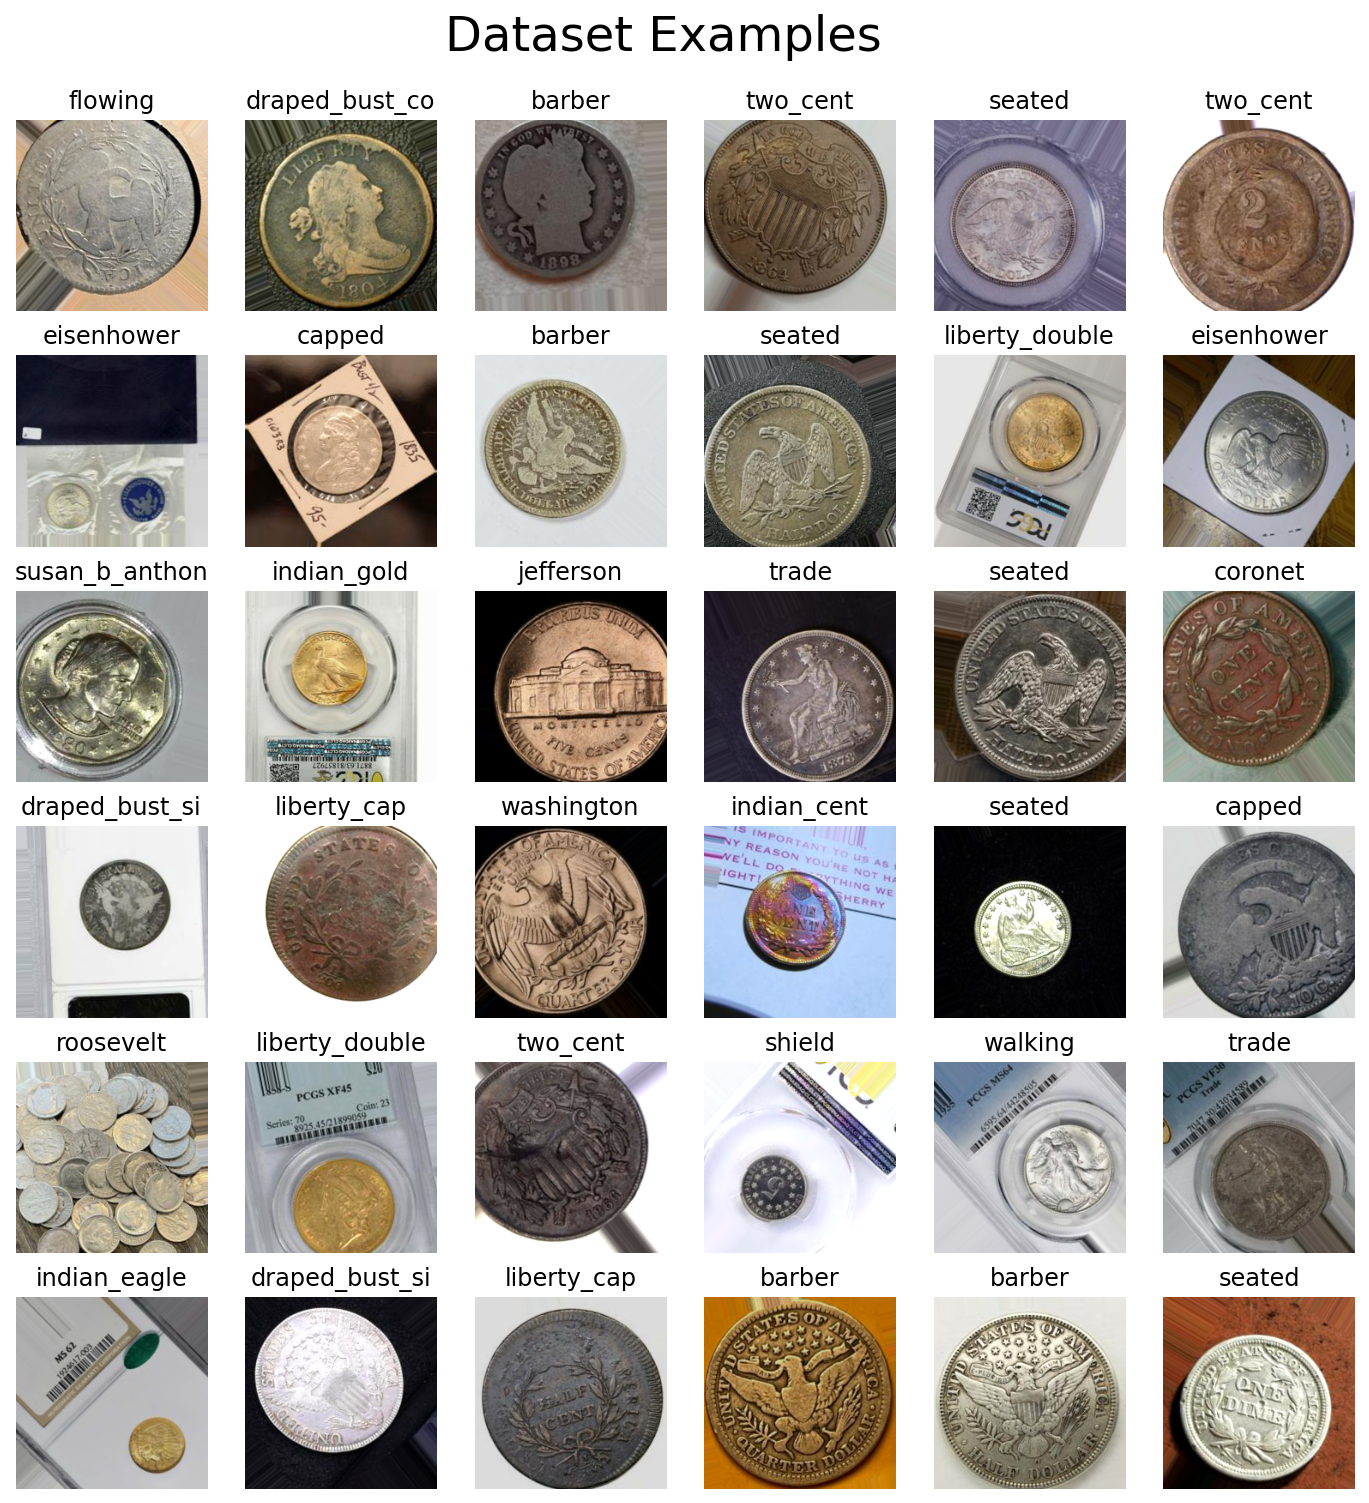

In [6]:
display_image_grid(*sample_dataset(train_generator, 36), title='Dataset Examples')

# Training

### Create ResNet Model

In [7]:
coin_classifier = ResNet50V2(classes=num_classes, weights=None)
trainable_param_count = np.sum([np.prod(layer.shape) for layer in coin_classifier.trainable_weights])
nontrainable_param_count = np.sum([np.prod(layer.shape) for layer in coin_classifier.non_trainable_weights])
print('>>>> ResNet50 Model Summary <<<<')
print(f'Input shape: {coin_classifier.input.shape[1:]}')
print(f'Output shape: {coin_classifier.output.shape[1:]}')
print(f'Number of layers: {len(coin_classifier.layers)}')
print(f'Number of trainable parameters: {trainable_param_count}')
print(f'Number of non-trainable parameters: {nontrainable_param_count}')
print(f'Total number of parameters: {trainable_param_count+nontrainable_param_count}')

>>>> ResNet50 Model Summary <<<<
Input shape: (224, 224, 3)
Output shape: (42,)
Number of layers: 192
Number of trainable parameters: 23605418
Number of non-trainable parameters: 45440
Total number of parameters: 23650858


### Train Model

In [ ]:
coin_classifier.compile(
  optimizer='adam', 
  loss='categorical_crossentropy',
  metrics=['accuracy', F1Score(num_classes)]
)
history = coin_classifier.fit(
  train_generator,
  callbacks=[
    EarlyStopping(monitor='val_accuracy', patience=20),
    ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', save_best_only=True),
  ],
  validation_data=test_generator,
  epochs=100,
)
coin_classifier = load_model(checkpoint_dir)

Epoch 1/100
399/399 [==============================] - 394s 945ms/step - loss: 3.1370 - accuracy: 0.1403 - f1_score: 0.0544 - val_loss: 3.9139 - val_accuracy: 0.0893 - val_f1_score: 0.0302
Epoch 2/100
399/399 [==============================] - 378s 946ms/step - loss: 2.8833 - accuracy: 0.1755 - f1_score: 0.0829 - val_loss: 3.1500 - val_accuracy: 0.1382 - val_f1_score: 0.0561
Epoch 3/100
399/399 [==============================] - 378s 948ms/step - loss: 2.7271 - accuracy: 0.2098 - f1_score: 0.1136 - val_loss: 3.2554 - val_accuracy: 0.1451 - val_f1_score: 0.0640
Epoch 4/100
399/399 [==============================] - 361s 904ms/step - loss: 2.5959 - accuracy: 0.2339 - f1_score: 0.1371 - val_loss: 4.2965 - val_accuracy: 0.0784 - val_f1_score: 0.0338
Epoch 5/100
399/399 [==============================] - 378s 947ms/step - loss: 2.4389 - accuracy: 0.2814 - f1_score: 0.1826 - val_loss: 2.6597 - val_accuracy: 0.2461 - val_f1_score: 0.1462
Epoch 6/100
399/399 [==============================] - 

### Save Training Metrics

In [ ]:
make_dir(metrics_dir)

train_losses = history.history['loss']
train_accuracies = history.history['accuracy']
train_f1_scores = history.history['f1_score']

test_losses = history.history['val_loss']
test_accuracies = history.history['val_accuracy']
test_f1_scores = history.history['val_f1_score']

np.save(f'{metrics_dir}/train_losses.npy', train_losses)
np.save(f'{metrics_dir}/train_accuracies.npy', train_accuracies)
np.save(f'{metrics_dir}/train_f1_scores.npy', train_f1_scores)

np.save(f'{metrics_dir}/test_losses.npy', test_losses)
np.save(f'{metrics_dir}/test_accuracies.npy', test_accuracies)
np.save(f'{metrics_dir}/test_f1_scores.npy', test_f1_scores)

### Save Model

In [ ]:
# save model the normal way
coin_classifier.save(model_dir)

# save model using tflite format
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
with open(tflite_dir, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/us_coin_classifier_env/coin_classifier/assets


# Evaluation

### Load Model and Metrics

In [8]:
coin_classifier = load_model(model_dir)

train_losses = np.load(f'{metrics_dir}/train_losses.npy')
train_accuracies = np.load(f'{metrics_dir}/train_accuracies.npy')
train_f1_scores = np.load(f'{metrics_dir}/train_f1_scores.npy')

test_losses = np.load(f'{metrics_dir}/test_losses.npy')
test_accuracies = np.load(f'{metrics_dir}/test_accuracies.npy')
test_f1_scores = np.load(f'{metrics_dir}/test_f1_scores.npy')

### Plot Metrics

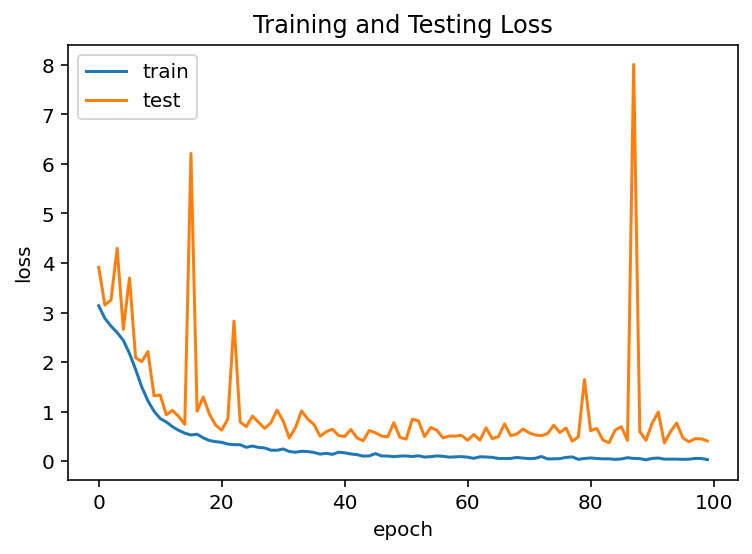

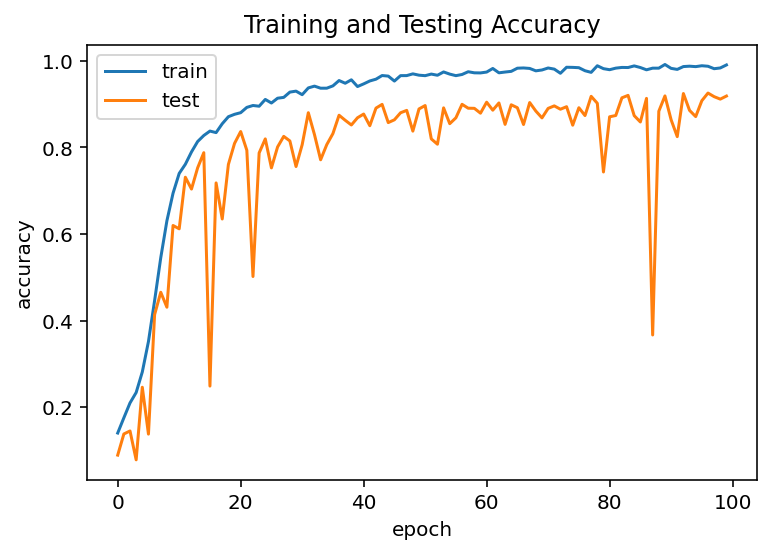

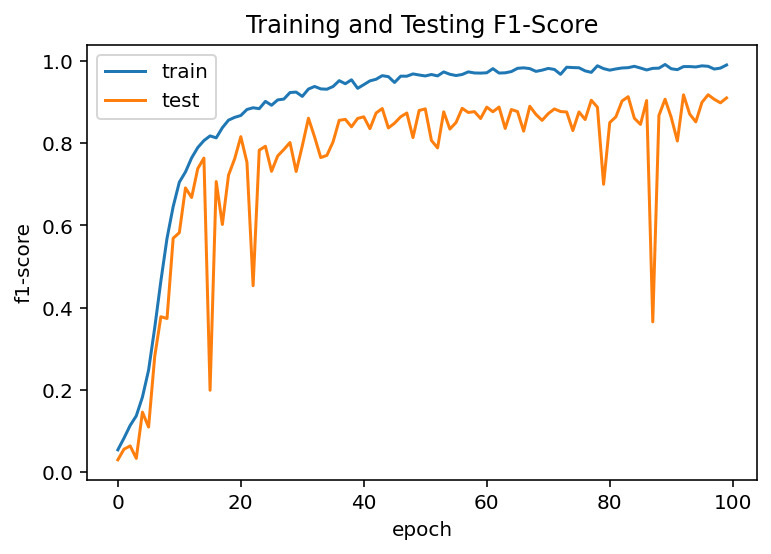

In [9]:
# plot losses
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Training and Testing Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

# plot accuracies
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.title('Training and Testing Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

# plot f1 scores
plt.plot(np.mean(train_f1_scores, axis=1))
plt.plot(np.mean(test_f1_scores, axis=1))
plt.title('Training and Testing F1-Score')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.legend(['train', 'test'])
plt.show()

### Plot Confusion Matrix

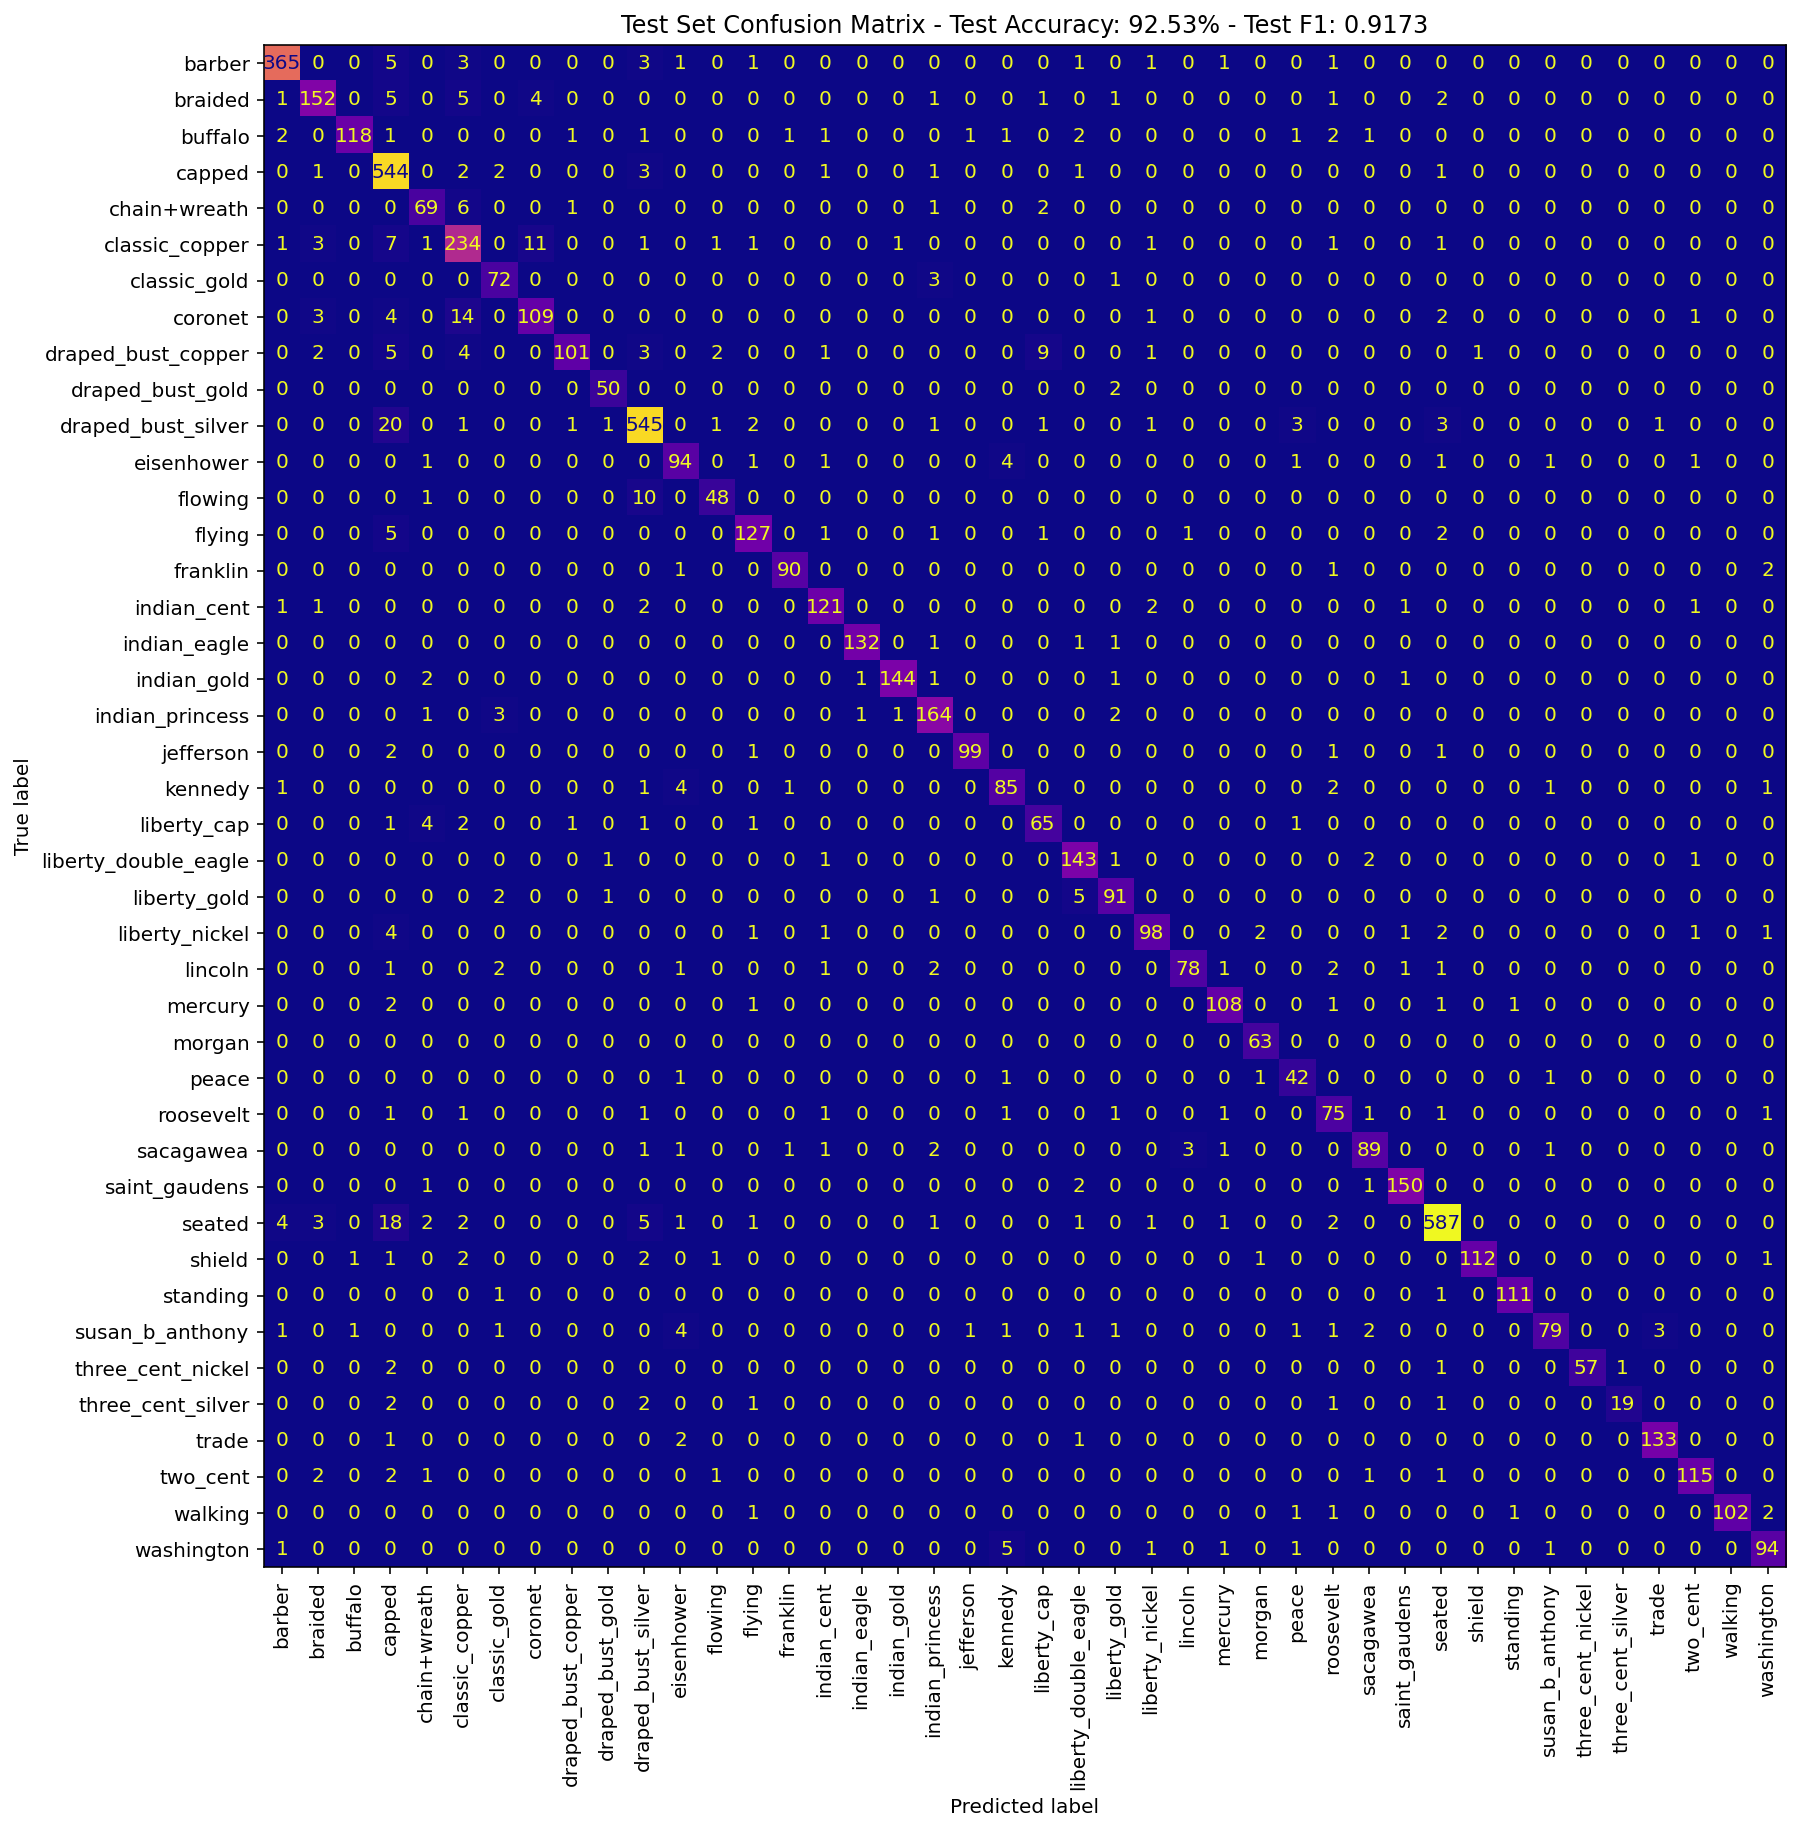

In [12]:
predictions = list(np.argmax(coin_classifier.predict(test_generator), axis=1))
true = list(test_generator.labels)

fig, ax = plt.subplots(figsize=(14, 14))
accuracy = round(accuracy_score(true, predictions) * 100, 2)
f1 = round(f1_score(true, predictions, average='macro'), 4)

conf_matrix = confusion_matrix(true, predictions)

ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot(
  xticks_rotation='vertical',
  cmap='plasma',
  ax=ax,
  colorbar=False,
)

plt.title(f'Test Set Confusion Matrix - Test Accuracy: {accuracy}% - Test F1: {f1}')
plt.show()

### Print Class Metrics

In [13]:
sort_by = 'f1'

precisions = precision_score(true, predictions, average=None)
recalls = recall_score(true, predictions, average=None)
f1_scores = f1_score(true, predictions, average=None)

if sort_by == 'precision':
  sorted_metric = sorted(enumerate(precisions), key=lambda x: x[1], reverse=True)
elif sort_by == 'recall':
  sorted_metric = sorted(enumerate(recalls), key=lambda x: x[1], reverse=True)
else:
   sorted_metric = sorted(enumerate(f1_scores), key=lambda x: x[1], reverse=True)

def get_mistakes(class_index):
  false_positives = sorted(enumerate(conf_matrix[:,class_index]), key=lambda x: x[1], reverse=True)
  false_negatives = sorted(enumerate(conf_matrix[class_index]), key=lambda x: x[1], reverse=True)
  false_positives = [(labels[i], count) for i, count in false_positives if count > 0 and i != class_index]
  false_negatives = [(labels[i], count) for i, count in false_negatives if count > 0 and i != class_index]
  return false_positives, false_negatives

for i, metric in sorted_metric:
  recall = metric if sort_by == 'recall' else recalls[i]
  precision = metric if sort_by == 'precision' else precisions[i]
  f1 = metric if sort_by == 'f1_score' else f1_scores[i]
  false_positives, false_negatives = get_mistakes(i)
  print(f'>>>> {labels[i]} <<<<')
  print(f'Precision: {round(precision * 100, 2)}%')
  print(f'Recall: {round(recall * 100, 2)}%')
  print(f'F1 Score: {round(f1, 4)}')
  print(f'False Positives: {false_positives}')
  print(f'False Negatives: {false_negatives}')
  print()

>>>> standing <<<<
Precision: 98.23%
Recall: 98.23%
F1 Score: 0.9823
False Positives: [('mercury', 1), ('walking', 1)]
False Negatives: [('classic_gold', 1), ('seated', 1)]

>>>> indian_eagle <<<<
Precision: 98.51%
Recall: 97.78%
F1 Score: 0.9814
False Positives: [('indian_gold', 1), ('indian_princess', 1)]
False Negatives: [('indian_princess', 1), ('liberty_double_eagle', 1), ('liberty_gold', 1)]

>>>> saint_gaudens <<<<
Precision: 97.4%
Recall: 97.4%
F1 Score: 0.974
False Positives: [('indian_cent', 1), ('indian_gold', 1), ('liberty_nickel', 1), ('lincoln', 1)]
False Negatives: [('liberty_double_eagle', 2), ('chain+wreath', 1), ('sacagawea', 1)]

>>>> indian_gold <<<<
Precision: 98.63%
Recall: 96.0%
F1 Score: 0.973
False Positives: [('classic_copper', 1), ('indian_princess', 1)]
False Negatives: [('chain+wreath', 2), ('indian_eagle', 1), ('indian_princess', 1), ('liberty_gold', 1), ('saint_gaudens', 1)]

>>>> walking <<<<
Precision: 100.0%
Recall: 94.44%
F1 Score: 0.9714
False Positi

### Make Predictions on Test Set

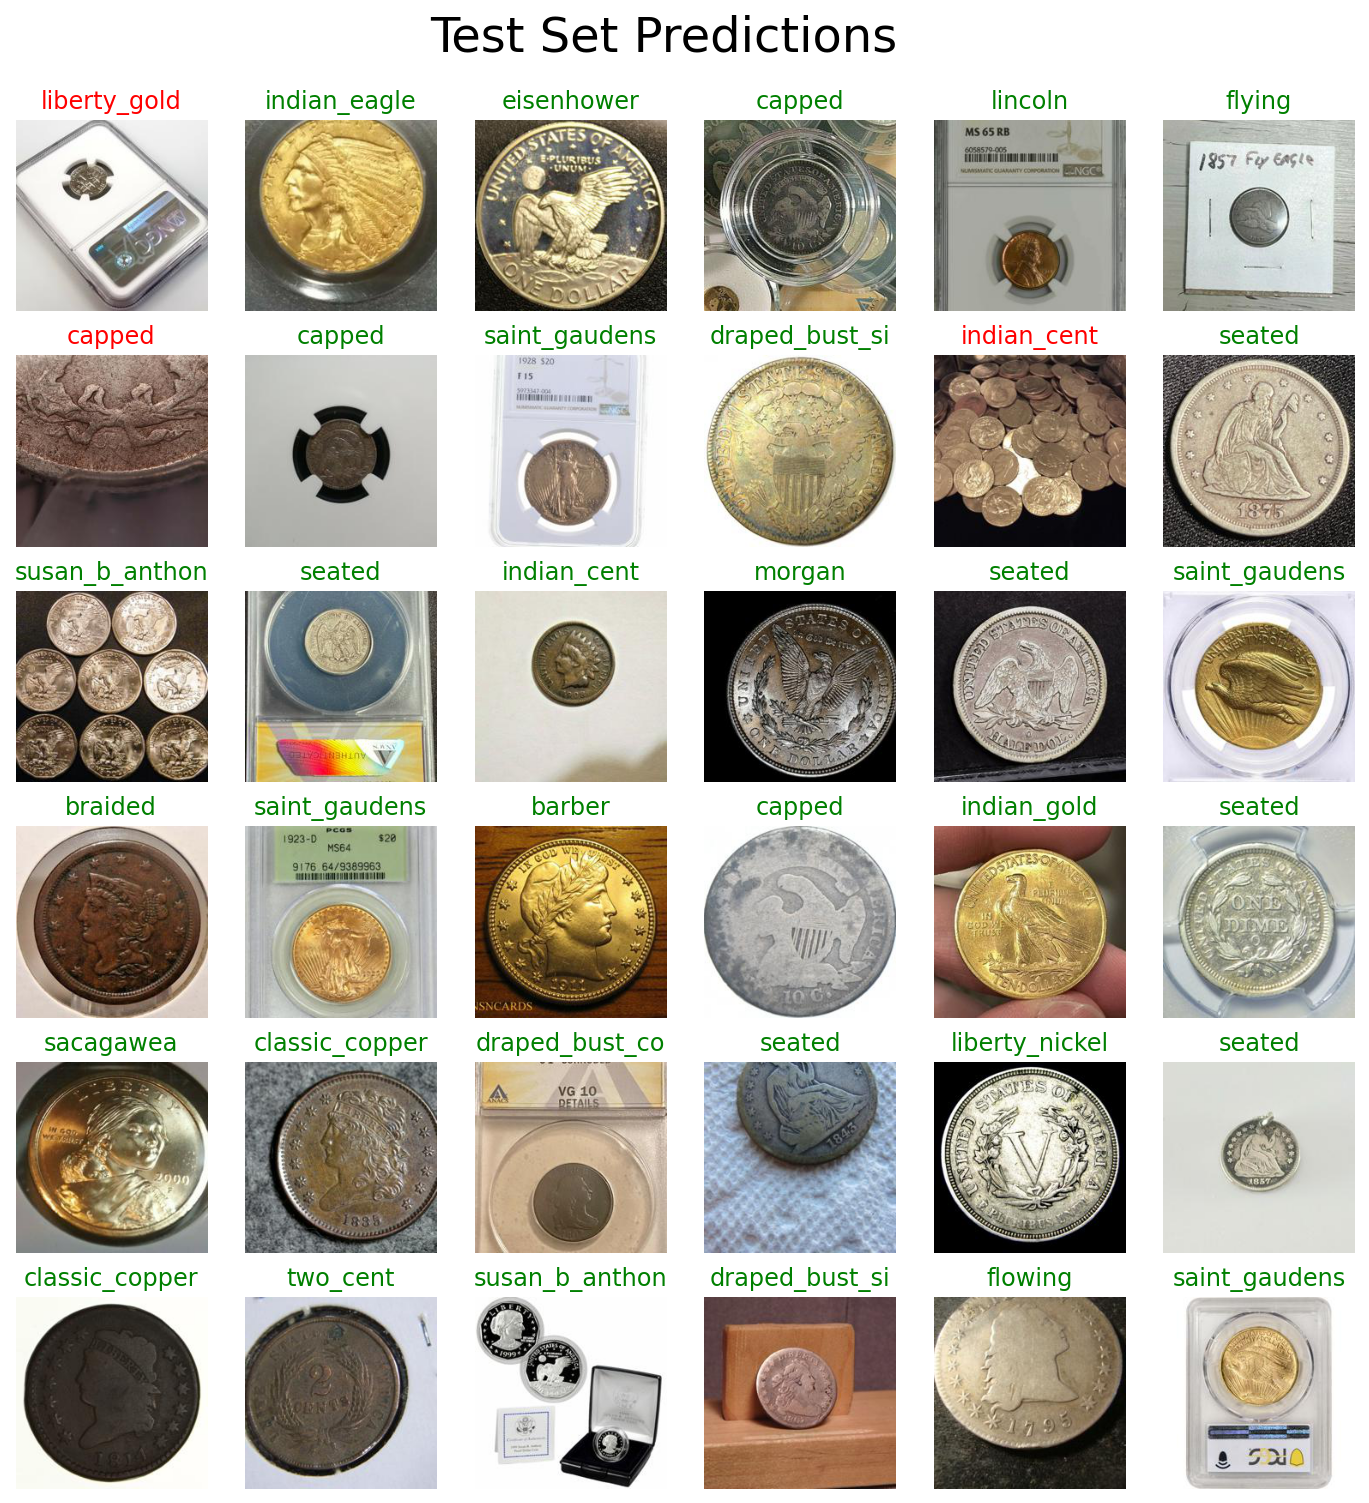

In [14]:
X, y_true = sample_dataset(test_generator_shuffled, 36)
y_pred = np.argmax(coin_classifier.predict(np.array(X)), axis=1)
y_pred_labels = [labels[y] for y in y_pred]

display_image_grid(X, y_pred_labels, y_true, title='Test Set Predictions')